In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [2]:
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'
path3 = '../Data/car_dataset/GE_제네시스/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
for folder, subfolders, filenames in os.walk(path3):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  180588
Image_labels: 180588


In [12]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        if img[24] == 'P':
            continue
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])
            
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  98882
Image_labels: 98882


In [3]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211206_HY_025_18_BL_A_P_01_054.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
1,C_211206_HY_025_18_BL_A_P_01_048.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
2,C_211206_HY_025_18_BL_A_T_02_005.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
3,C_211206_HY_025_18_BL_A_P_01_025.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
4,C_211206_HY_025_18_BL_A_T_03_001.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
...,...,...,...
180583,C_211014_GE_018_20_BL_A_T_03_014.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180584,C_211014_GE_018_20_BL_A_T_03_009.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180585,C_211014_GE_018_20_BL_A_P_01_062.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180586,C_211014_GE_018_20_BL_A_P_01_016.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020


In [4]:
train['label'].value_counts()

현대/코나/2018         2755
기아/모닝/2017         2721
기아/K3/2019         2563
기아/스포티지/2018       2471
제네시스/G80/2018      2431
                   ... 
현대/아이오닉/2021        182
제네시스/EQ900/2019      95
현대/벨로스터/2021         95
현대/벨로스터/2017         95
기아/셀토스/2018          95
Name: label, Length: 160, dtype: int64

In [5]:
train['label'].value_counts().loc[lambda x : x > 900]

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
현대/코나/2020        940
기아/니로/2018        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [4]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['기아/K5/2021', '기아/K7/2021', '기아/K9/2017', '기아/K9/2018', '기아/니로/2021',
       '기아/레이/2021', '기아/모하비/2019', '기아/모하비/2020', '기아/모하비/2021',
       '기아/봉고3/2018', '기아/봉고3/2019', '기아/봉고3/2020', '기아/봉고3/2021',
       '기아/셀토스/2018', '기아/셀토스/2019', '기아/셀토스/2020', '기아/스토닉/2017',
       '기아/스토닉/2020', '기아/스토닉/2021', '기아/스팅어/2017', '기아/스팅어/2021',
       '기아/스포티지/2020', '기아/스포티지/2021', '기아/쏘울/2017', '기아/쏘울/2018',
       '기아/쏘울/2019', '기아/카니발/2021', '제네시스/EQ900/2019', '제네시스/G70/2020',
       '제네시스/G70/2021', '제네시스/G80/2020', '제네시스/G90/2020', '제네시스/G90/2021',
       '제네시스/GV80/2020', '제네시스/GV80/2021', '현대/i30/2017', '현대/i30/2018',
       '현대/i30/2019', '현대/넥쏘/2020', '현대/맥스크루즈/2017', '현대/맥스크루즈/2018',
       '현대/베뉴/2019', '현대/베뉴/2021', '현대/벨로스터/2017', '현대/벨로스터/2018',
       '현대/벨로스터/2019', '현대/벨로스터/2020', '현대/벨로스터/2021', '현대/스타렉스/2021',
       '현대/싼타페/2021', '현대/아이오닉/2017', '현대/아이오닉/2018', '현대/아이오닉/2019',
       '현대/아이오닉/2020', '현대/아이오닉/2021', '현대/엑센트/2017', '현대/엑센트/2018',
       '현대/엑센트/2019', 

In [5]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018


In [6]:
train['label'].value_counts()

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
기아/니로/2018        940
현대/코나/2020        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [7]:
print(len(train.label))

206646


In [7]:
train.label.nunique()

134

In [7]:
label_value = train['label'].values
label_value

array(['현대/베뉴/2020', '현대/베뉴/2020', '현대/베뉴/2020', ..., '제네시스/G70/2018',
       '제네시스/G70/2018', '제네시스/G70/2018'], dtype=object)

In [8]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53


In [9]:
le.classes_

array(['기아/K3/2017', '기아/K3/2018', '기아/K3/2019', '기아/K3/2020',
       '기아/K3/2021', '기아/K5/2017', '기아/K5/2018', '기아/K5/2019',
       '기아/K5/2020', '기아/K7/2017', '기아/K7/2018', '기아/K7/2019',
       '기아/K7/2020', '기아/K9/2019', '기아/K9/2020', '기아/K9/2021',
       '기아/니로/2017', '기아/니로/2018', '기아/니로/2019', '기아/니로/2020',
       '기아/레이/2017', '기아/레이/2018', '기아/레이/2019', '기아/레이/2020',
       '기아/모닝/2017', '기아/모닝/2018', '기아/모닝/2019', '기아/모닝/2020',
       '기아/모닝/2021', '기아/모하비/2017', '기아/모하비/2018', '기아/봉고3/2017',
       '기아/셀토스/2021', '기아/스토닉/2018', '기아/스토닉/2019', '기아/스팅어/2018',
       '기아/스팅어/2019', '기아/스팅어/2020', '기아/스포티지/2017', '기아/스포티지/2018',
       '기아/스포티지/2019', '기아/쏘렌토/2017', '기아/쏘렌토/2018', '기아/쏘렌토/2019',
       '기아/쏘렌토/2020', '기아/쏘렌토/2021', '기아/카니발/2017', '기아/카니발/2018',
       '기아/카니발/2019', '기아/카니발/2020', '제네시스/EQ900/2017', '제네시스/EQ900/2018',
       '제네시스/G70/2017', '제네시스/G70/2018', '제네시스/G70/2019', '제네시스/G80/2017',
       '제네시스/G80/2018', '제네시스/G80/2019', '제네시스/G80/2021', '제네시스/G90/2019

In [35]:
dist.destroy_process_group()

In [10]:
project_name = 'preprocessed_ef_ns04_HK02'
user = 'hojunking'
run_name = 'preprocessed_ef_ns_04_HK02'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 0.9799: 100%|█████████████████| 8725/8725 [45:13<00:00,  3.22it/s]

train accuracy = 0.46338
[[1239  286  107 ...    1    2    0]
 [ 457  692  137 ...    0    0    3]
 [ 121  174  671 ...    0    0    5]
 ...
 [   4    0    1 ...  988  443   10]
 [  10    1    0 ...  599  823   14]
 [   4    0    2 ...    2    2 1776]]



epoch 0 loss: 1.0547: 100%|█████████████████| 1860/1860 [04:24<00:00,  7.02it/s]


validation accuracy = 0.56203
[[207  35  19 ...   0   1   0]
 [ 57 107  24 ...   0   0   0]
 [  2  28 271 ...   0   0   0]
 ...
 [  0   0   0 ... 117  18   1]
 [  0   0   0 ...  73 106   0]
 [  0   0   0 ...   0   0 210]]


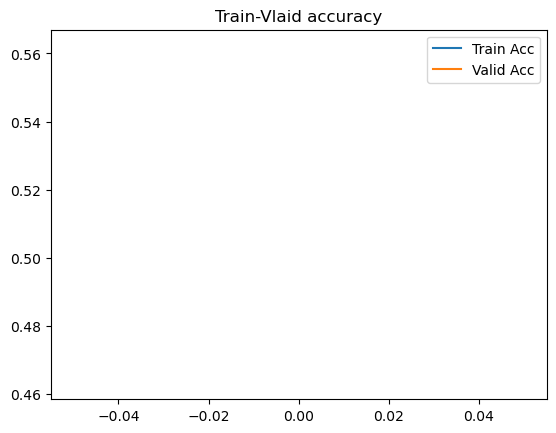

epoch 1 loss: 0.6814: 100%|█████████████████| 8725/8725 [44:01<00:00,  3.30it/s]


train accuracy = 0.68844
[[1724  208   90 ...    0    0    0]
 [ 275 1453   91 ...    1    1    0]
 [  58  169 1189 ...    0    0    0]
 ...
 [   0    0    0 ... 1656  275    0]
 [   1    0    0 ...  458 1415    1]
 [   0    1    0 ...    0    1 2117]]


epoch 1 loss: 0.8707: 100%|█████████████████| 1860/1860 [04:24<00:00,  7.04it/s]


validation accuracy = 0.66005
[[249  23   4 ...   0   0   0]
 [ 38 175   6 ...   0   0   0]
 [ 14  59 225 ...   0   0   0]
 ...
 [  0   0   1 ... 121  20   0]
 [  0   0   0 ...  47 132   0]
 [  0   0   0 ...   0   0 214]]


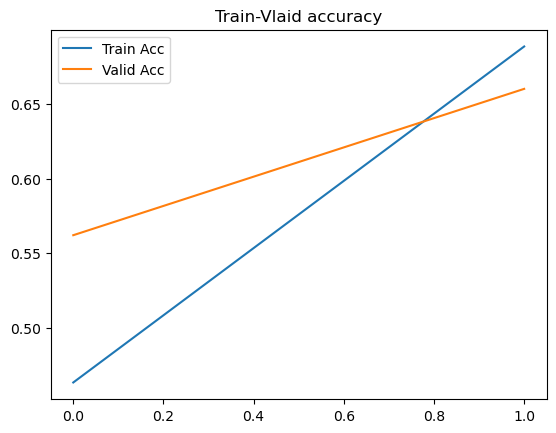

epoch 2 loss: 0.5110: 100%|█████████████████| 8725/8725 [44:02<00:00,  3.30it/s]


train accuracy = 0.78623
[[1930  121   55 ...    0    0    0]
 [ 143 1743  112 ...    3    0    0]
 [  46  171 1486 ...    0    0    0]
 ...
 [   0    0    0 ... 1855  197    0]
 [   0    0    0 ...  294 1705    0]
 [   0    0    0 ...    0    1 2140]]


epoch 2 loss: 0.7533: 100%|█████████████████| 1860/1860 [04:24<00:00,  7.03it/s]


validation accuracy = 0.72188
[[231  44  10 ...   0   0   0]
 [ 11 208   8 ...   0   1   0]
 [  6  49 342 ...   0   0   0]
 ...
 [  0   0   0 ... 146  29   0]
 [  0   0   0 ...  45 163   0]
 [  0   0   0 ...   0   0 220]]


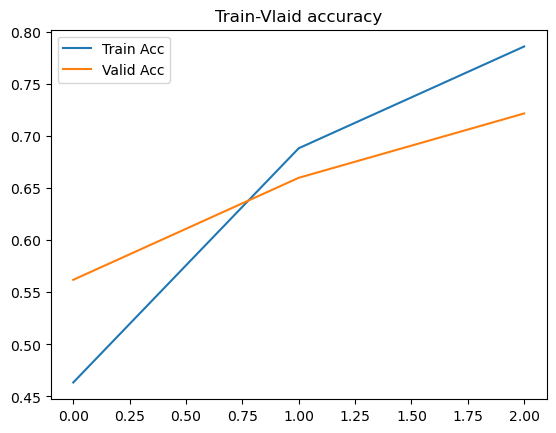

epoch 3 loss: 0.3967: 100%|█████████████████| 8725/8725 [44:03<00:00,  3.30it/s]


train accuracy = 0.84305
[[2017   81   39 ...    0    0    0]
 [  97 1861   94 ...    1    0    0]
 [  33  152 1633 ...    0    2    0]
 ...
 [   0    0    0 ... 1950  146    1]
 [   0    0    0 ...  209 1872    0]
 [   0    0    0 ...    0    0 2168]]


epoch 3 loss: 0.6837: 100%|█████████████████| 1860/1860 [04:24<00:00,  7.03it/s]


validation accuracy = 0.75612
[[249  22   9 ...   0   0   0]
 [  7 203  18 ...   0   1   0]
 [  8  50 331 ...   0   0   0]
 ...
 [  0   0   0 ... 156  11   0]
 [  0   0   0 ...  44 156   0]
 [  0   0   0 ...   0   0 220]]


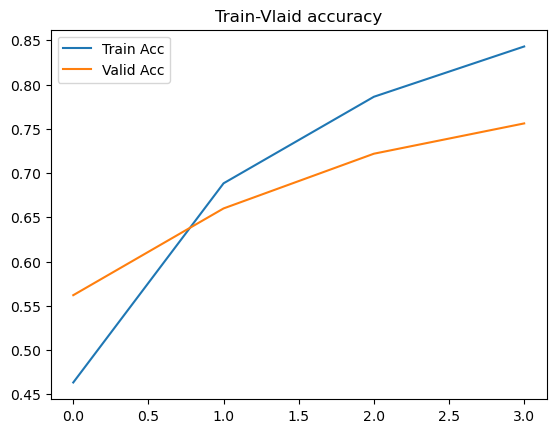

epoch 4 loss: 0.3470: 100%|█████████████████| 8725/8725 [44:05<00:00,  3.30it/s]


train accuracy = 0.87626
[[2063   59   26 ...    0    0    0]
 [  68 1948   85 ...    0    0    0]
 [  31  123 1746 ...    0    0    0]
 ...
 [   0    0    0 ... 2032   89    0]
 [   0    0    0 ...  122 1973    1]
 [   0    0    0 ...    0    0 2180]]


epoch 4 loss: 0.6726: 100%|█████████████████| 1860/1860 [04:24<00:00,  7.03it/s]


validation accuracy = 0.77396
[[247  23  18 ...   0   0   0]
 [ 12 215  12 ...   0   1   0]
 [  6  48 349 ...   0   0   0]
 ...
 [  0   0   0 ... 141  23   0]
 [  0   0   0 ...  19 176   0]
 [  0   0   0 ...   0   0 217]]


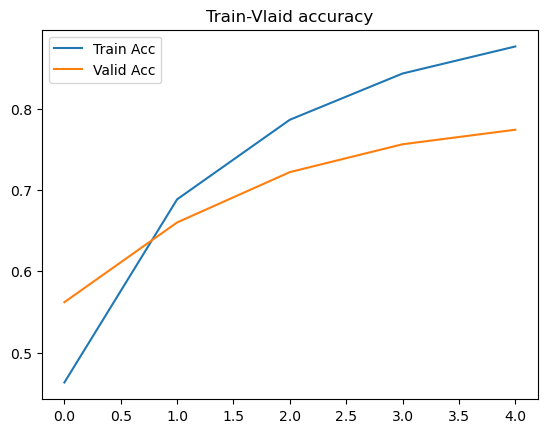

epoch 5 loss: 0.2558: 100%|█████████████████| 8725/8725 [44:06<00:00,  3.30it/s]


train accuracy = 0.89868
[[2084   44   25 ...    0    0    0]
 [  42 2011   62 ...    0    0    0]
 [  23  107 1837 ...    0    0    0]
 ...
 [   0    0    0 ... 2055   88    0]
 [   0    0    0 ...  114 2015    0]
 [   0    0    0 ...    0    0 2174]]


epoch 5 loss: 0.6731: 100%|█████████████████| 1860/1860 [04:25<00:00,  7.00it/s]


validation accuracy = 0.78774
[[268  11   6 ...   0   0   0]
 [ 14 194  25 ...   0   1   0]
 [  8  54 357 ...   0   0   0]
 ...
 [  0   0   0 ... 160  11   0]
 [  1   0   0 ...  29 187   0]
 [  0   0   0 ...   0   0 214]]


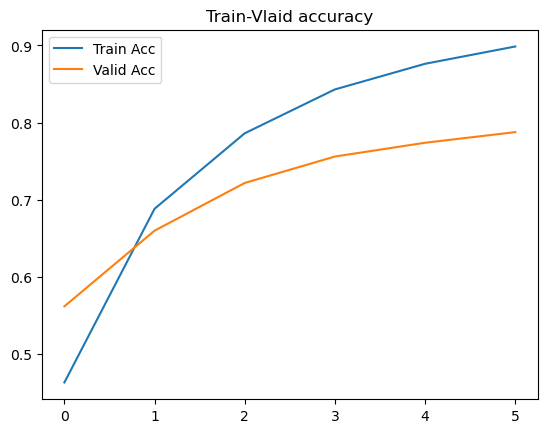

epoch 6 loss: 0.2415: 100%|█████████████████| 8725/8725 [44:07<00:00,  3.30it/s]


train accuracy = 0.91317
[[2113   32   18 ...    0    0    0]
 [  38 2031   60 ...    0    0    0]
 [  15  100 1867 ...    3    0    0]
 ...
 [   0    0    0 ... 2086   75    0]
 [   0    0    0 ...  106 2033    1]
 [   0    0    0 ...    0    0 2180]]


epoch 6 loss: 0.6589: 100%|█████████████████| 1860/1860 [04:25<00:00,  7.00it/s]


validation accuracy = 0.79751
[[267   9   9 ...   0   0   0]
 [ 12 207  28 ...   0   1   0]
 [  2  32 412 ...   0   0   0]
 ...
 [  0   0   0 ... 147  26   1]
 [  0   0   0 ...  14 197   0]
 [  0   0   0 ...   0   0 217]]


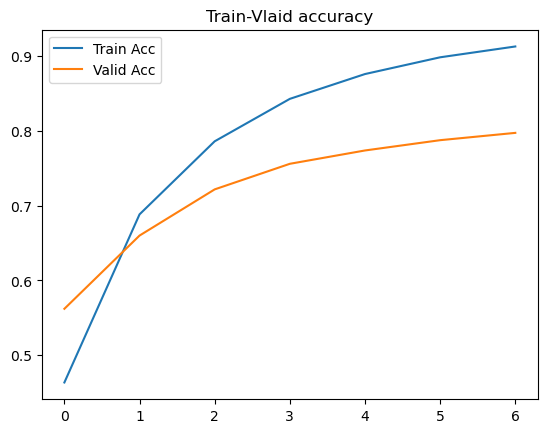

epoch 7 loss: 0.2238: 100%|█████████████████| 8725/8725 [44:08<00:00,  3.29it/s]


train accuracy = 0.92357
[[2117   29   17 ...    0    0    0]
 [  41 2023   69 ...    0    0    0]
 [  11  103 1891 ...    0    0    0]
 ...
 [   1    0    0 ... 2099   66    0]
 [   0    0    0 ...   78 2071    0]
 [   0    0    0 ...    0    0 2176]]


epoch 7 loss: 0.6675: 100%|█████████████████| 1860/1860 [04:25<00:00,  7.01it/s]


validation accuracy = 0.80410
[[282   5   9 ...   0   0   0]
 [ 12 204  22 ...   0   1   0]
 [  9  44 380 ...   0   0   0]
 ...
 [  0   0   0 ... 157  14   0]
 [  1   0   0 ...  27 189   0]
 [  0   0   0 ...   0   0 221]]


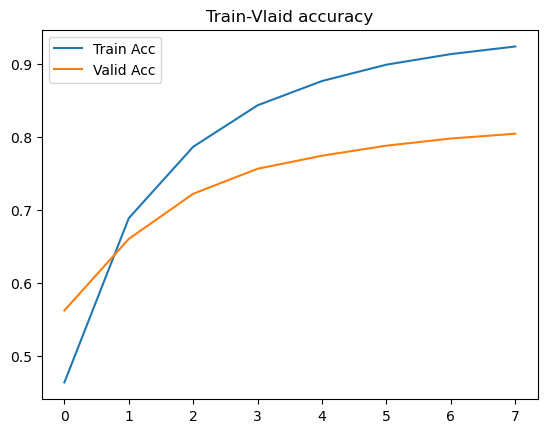

epoch 8 loss: 0.1786: 100%|█████████████████| 8725/8725 [44:10<00:00,  3.29it/s]


train accuracy = 0.93215
[[2123   28   16 ...    0    0    0]
 [  26 2049   51 ...    0    0    0]
 [  12   86 1937 ...    0    0    0]
 ...
 [   0    0    0 ... 2104   63    0]
 [   0    0    0 ...   76 2084    0]
 [   0    0    0 ...    1    0 2189]]


epoch 8 loss: 0.6858: 100%|█████████████████| 1860/1860 [04:25<00:00,  6.99it/s]


validation accuracy = 0.80712
[[262  18   6 ...   0   0   0]
 [  7 216  15 ...   0   1   0]
 [ 11  48 362 ...   0   0   0]
 ...
 [  0   0   0 ... 161  13   0]
 [  0   0   0 ...  32 186   0]
 [  0   0   0 ...   0   0 218]]


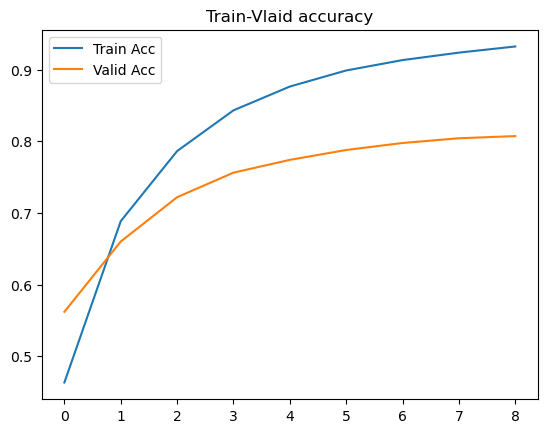

epoch 9 loss: 0.1651: 100%|█████████████████| 8725/8725 [44:12<00:00,  3.29it/s]


train accuracy = 0.93937
[[2140   22   13 ...    0    0    0]
 [  18 2076   45 ...    0    0    0]
 [  10   82 1977 ...    0    0    0]
 ...
 [   0    0    0 ... 2123   53    0]
 [   0    0    0 ...   61 2102    0]
 [   0    0    0 ...    0    0 2186]]


epoch 9 loss: 0.6556: 100%|█████████████████| 1860/1860 [04:26<00:00,  6.98it/s]


validation accuracy = 0.81216
[[269  10   5 ...   0   0   0]
 [  9 215  23 ...   0   1   0]
 [  5  39 391 ...   0   0   0]
 ...
 [  0   0   0 ... 158  18   0]
 [  0   0   0 ...  39 168   0]
 [  0   0   0 ...   0   0 219]]


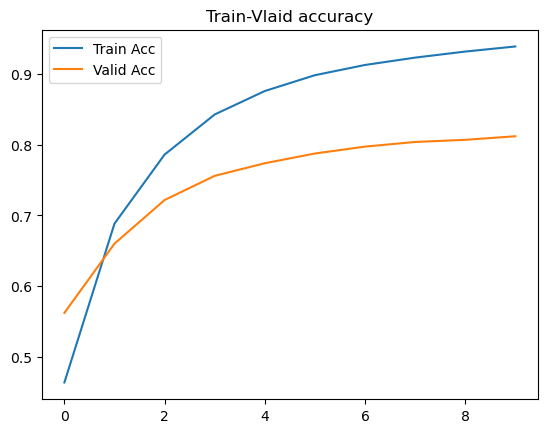

epoch 10 loss: 0.1470: 100%|████████████████| 8725/8725 [44:19<00:00,  3.28it/s]


train accuracy = 0.94450
[[2135   21   14 ...    0    0    0]
 [  25 2086   49 ...    0    0    0]
 [  12   60 1982 ...    0    0    0]
 ...
 [   0    0    0 ... 2112   59    0]
 [   0    0    0 ...   67 2100    0]
 [   0    0    0 ...    0    0 2184]]


epoch 10 loss: 0.6820: 100%|████████████████| 1860/1860 [04:26<00:00,  6.98it/s]


validation accuracy = 0.81112
[[273   9   9 ...   0   0   0]
 [ 14 222   8 ...   0   0   0]
 [  3  62 367 ...   0   0   0]
 ...
 [  0   0   0 ... 164  15   0]
 [  0   0   0 ...  32 178   0]
 [  0   0   0 ...   0   0 222]]


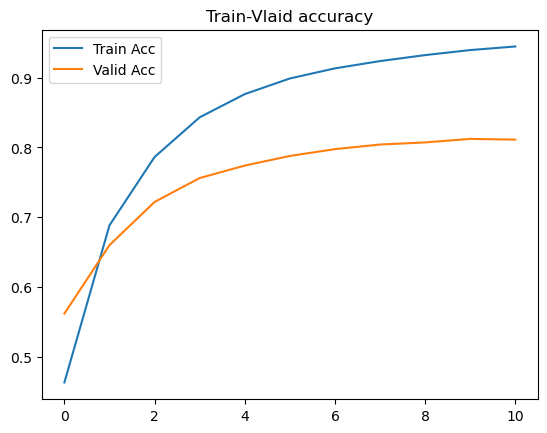

epoch 11 loss: 0.1572: 100%|████████████████| 8725/8725 [44:15<00:00,  3.29it/s]


train accuracy = 0.94964
[[2147   17   13 ...    0    0    0]
 [  19 2116   26 ...    0    0    0]
 [   8   62 1981 ...    0    0    0]
 ...
 [   0    0    0 ... 2124   50    0]
 [   0    0    0 ...   63 2099    0]
 [   0    0    0 ...    0    0 2188]]


epoch 11 loss: 0.6419: 100%|████████████████| 1860/1860 [04:26<00:00,  6.98it/s]


validation accuracy = 0.82571
[[284   3   1 ...   0   0   0]
 [  8 216  31 ...   0   1   0]
 [ 12  36 422 ...   0   0   0]
 ...
 [  0   0   0 ... 160  12   1]
 [  0   0   0 ...  35 182   0]
 [  0   0   0 ...   0   0 220]]


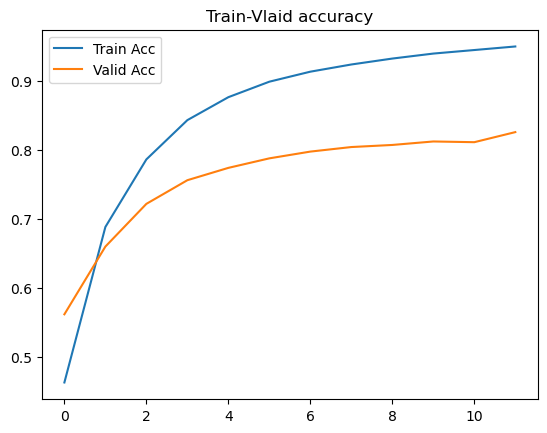

epoch 12 loss: 0.1481: 100%|████████████████| 8725/8725 [44:37<00:00,  3.26it/s]


train accuracy = 0.95198
[[2149   23    8 ...    0    0    0]
 [  20 2102   41 ...    0    0    0]
 [   8   66 2005 ...    0    0    0]
 ...
 [   0    0    0 ... 2128   48    0]
 [   0    0    0 ...   54 2123    0]
 [   0    0    0 ...    0    0 2183]]


epoch 12 loss: 0.6539: 100%|████████████████| 1860/1860 [04:27<00:00,  6.96it/s]


validation accuracy = 0.82308
[[280   5   2 ...   0   0   0]
 [  7 211  29 ...   0   1   0]
 [ 16  37 390 ...   0   0   0]
 ...
 [  0   0   0 ... 154  21   0]
 [  0   0   0 ...  21 197   0]
 [  0   0   0 ...   0   0 218]]


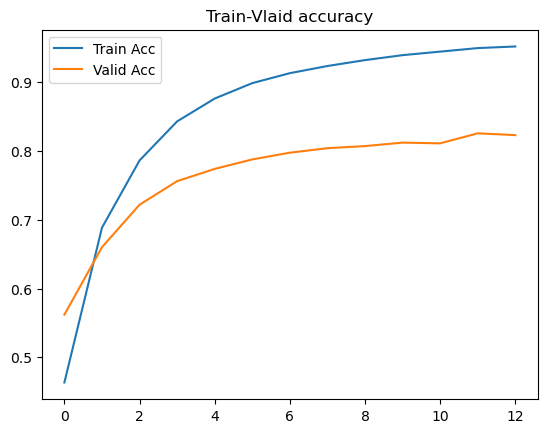

epoch 13 loss: 0.1661: 100%|████████████████| 8725/8725 [44:24<00:00,  3.27it/s]


train accuracy = 0.95522
[[2159   15    7 ...    0    0    0]
 [  20 2098   42 ...    0    0    1]
 [   6   51 2029 ...    0    0    0]
 ...
 [   0    0    0 ... 2146   38    0]
 [   0    0    0 ...   54 2107    0]
 [   0    0    0 ...    0    1 2185]]


epoch 13 loss: 0.6317: 100%|████████████████| 1860/1860 [04:27<00:00,  6.96it/s]


validation accuracy = 0.82947
[[282   9   3 ...   0   0   0]
 [  6 237   5 ...   0   1   0]
 [  7  57 395 ...   0   0   0]
 ...
 [  0   0   0 ... 157  19   0]
 [  0   0   0 ...  19 188   0]
 [  0   0   0 ...   0   0 216]]


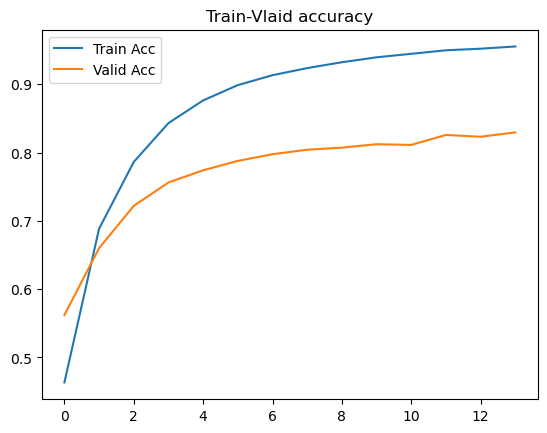

epoch 14 loss: 0.1349: 100%|████████████████| 8725/8725 [44:20<00:00,  3.28it/s]


train accuracy = 0.95927
[[2167   16    5 ...    0    0    0]
 [  21 2109   43 ...    0    0    0]
 [   6   59 2017 ...    0    0    0]
 ...
 [   0    0    0 ... 2134   49    0]
 [   0    0    0 ...   51 2123    0]
 [   0    0    0 ...    0    0 2192]]


epoch 14 loss: 0.6684: 100%|████████████████| 1860/1860 [04:27<00:00,  6.96it/s]


validation accuracy = 0.82812
[[288   1   2 ...   0   0   0]
 [ 11 207  29 ...   0   1   0]
 [ 13  36 395 ...   0   0   0]
 ...
 [  0   0   0 ... 160  17   0]
 [  0   0   0 ...  19 196   0]
 [  0   0   0 ...   0   0 215]]


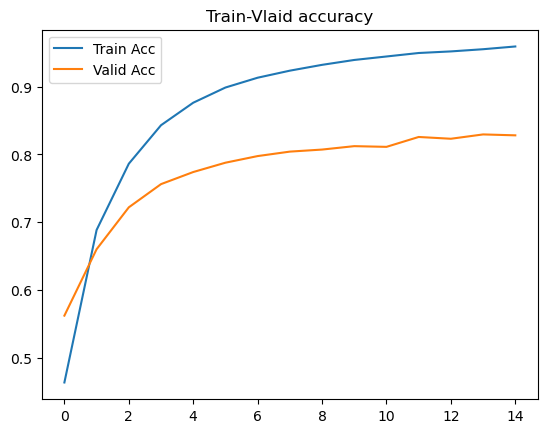

epoch 15 loss: 0.1282: 100%|████████████████| 8725/8725 [44:23<00:00,  3.28it/s]


train accuracy = 0.96053
[[2166   11    4 ...    0    0    1]
 [  13 2112   42 ...    0    0    0]
 [   5   53 2025 ...    0    0    0]
 ...
 [   0    0    0 ... 2155   34    0]
 [   0    0    0 ...   44 2137    0]
 [   0    0    1 ...    1    0 2190]]


epoch 15 loss: 0.7178: 100%|████████████████| 1860/1860 [04:28<00:00,  6.94it/s]


validation accuracy = 0.82856
[[280   1  10 ...   0   0   0]
 [  9 206  36 ...   0   1   0]
 [  4  29 425 ...   0   0   0]
 ...
 [  0   0   0 ... 160  13   0]
 [  0   0   0 ...  22 185   0]
 [  0   0   0 ...   0   0 219]]


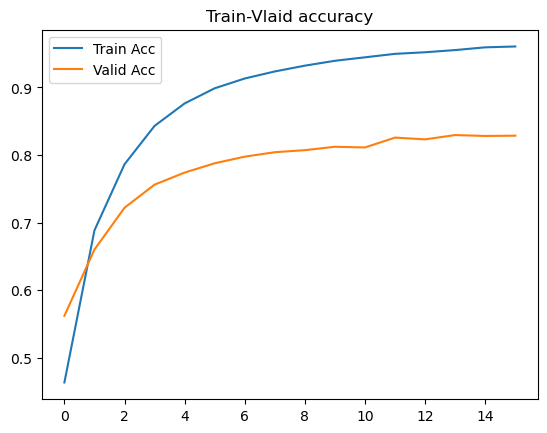

epoch 16 loss: 0.1018: 100%|████████████████| 8725/8725 [44:27<00:00,  3.27it/s]


train accuracy = 0.96200
[[2161   18    6 ...    0    0    0]
 [  16 2120   39 ...    0    0    0]
 [   5   44 2046 ...    0    0    0]
 ...
 [   0    0    0 ... 2141   34    0]
 [   0    0    1 ...   36 2146    0]
 [   0    0    0 ...    0    0 2189]]


epoch 16 loss: 0.6757: 100%|████████████████| 1860/1860 [04:27<00:00,  6.95it/s]


validation accuracy = 0.83162
[[275   5  10 ...   0   0   0]
 [  3 217  25 ...   0   1   0]
 [  6  34 412 ...   0   0   0]
 ...
 [  0   0   0 ... 160  14   0]
 [  0   0   0 ...  12 200   0]
 [  0   0   0 ...   0   0 213]]


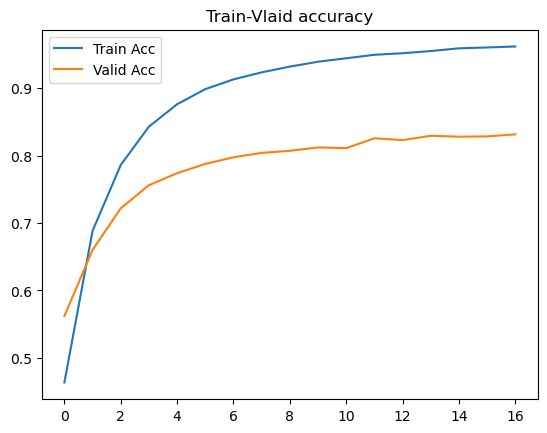

epoch 17 loss: 0.0962: 100%|████████████████| 8725/8725 [44:26<00:00,  3.27it/s]


train accuracy = 0.96473
[[2174    9    4 ...    0    0    0]
 [  10 2115   36 ...    0    0    0]
 [   8   50 2054 ...    0    0    0]
 ...
 [   0    0    0 ... 2141   43    0]
 [   0    0    0 ...   44 2134    1]
 [   1    0    0 ...    0    0 2185]]


epoch 17 loss: 0.6709: 100%|████████████████| 1860/1860 [04:28<00:00,  6.93it/s]


validation accuracy = 0.83565
[[259  17   9 ...   0   0   0]
 [  2 225  23 ...   0   1   0]
 [  3  44 405 ...   0   0   0]
 ...
 [  0   1   0 ... 173   5   0]
 [  0   0   0 ...  37 174   0]
 [  0   0   0 ...   0   0 218]]


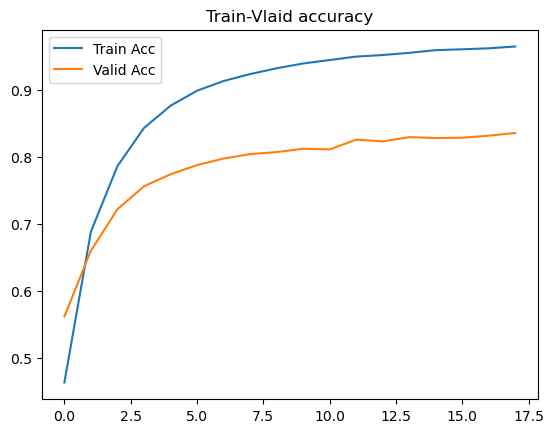

epoch 18 loss: 0.1084: 100%|████████████████| 8725/8725 [44:26<00:00,  3.27it/s]


train accuracy = 0.96621
[[2164   14    7 ...    0    0    0]
 [  16 2129   36 ...    0    0    0]
 [   7   49 2053 ...    0    0    0]
 ...
 [   0    0    0 ... 2142   40    0]
 [   0    0    0 ...   42 2138    0]
 [   0    0    0 ...    0    0 2193]]


epoch 18 loss: 0.7035: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.83364
[[266   7  10 ...   0   0   0]
 [  5 209  35 ...   0   1   0]
 [  1  30 449 ...   0   0   0]
 ...
 [  0   0   0 ... 167   6   0]
 [  0   0   0 ...  36 169   0]
 [  0   0   0 ...   0   0 217]]


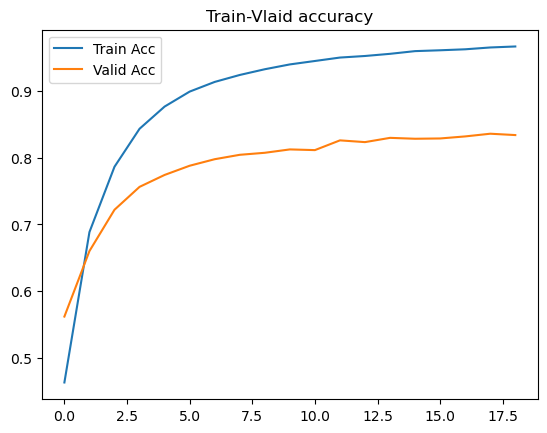

epoch 19 loss: 0.1218: 100%|████████████████| 8725/8725 [44:29<00:00,  3.27it/s]


train accuracy = 0.96721
[[2167   12    4 ...    0    2    0]
 [  13 2143   25 ...    0    0    0]
 [   3   35 2074 ...    0    0    0]
 ...
 [   0    0    0 ... 2157   26    0]
 [   0    0    0 ...   35 2145    0]
 [   0    0    0 ...    1    0 2191]]


epoch 19 loss: 0.6816: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.83451
[[275   9   3 ...   0   0   0]
 [  8 231  12 ...   0   1   0]
 [  7  54 388 ...   0   0   0]
 ...
 [  0   0   0 ... 164  14   0]
 [  0   0   0 ...  19 191   0]
 [  0   0   0 ...   0   0 216]]


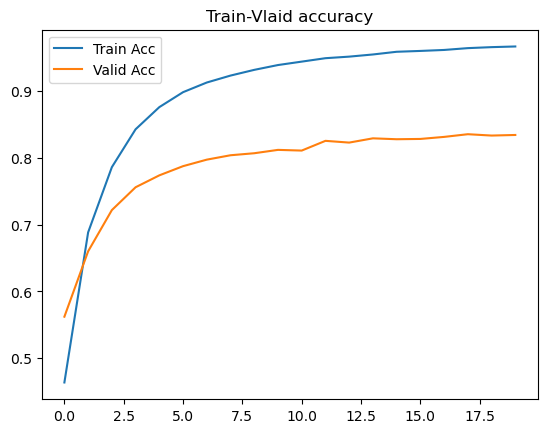

epoch 20 loss: 0.0884: 100%|████████████████| 8725/8725 [44:30<00:00,  3.27it/s]


train accuracy = 0.96885
[[2172    6    8 ...    0    0    0]
 [  10 2142   24 ...    0    2    0]
 [   3   35 2067 ...    0    0    0]
 ...
 [   0    0    0 ... 2155   31    0]
 [   0    0    1 ...   38 2140    0]
 [   0    0    0 ...    0    0 2192]]


epoch 20 loss: 0.6888: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.83945
[[274  10   3 ...   0   0   0]
 [  5 229  19 ...   0   1   0]
 [  4  40 403 ...   0   0   0]
 ...
 [  0   0   0 ... 164   8   0]
 [  1   1   0 ...  14 195   0]
 [  0   0   0 ...   0   0 218]]


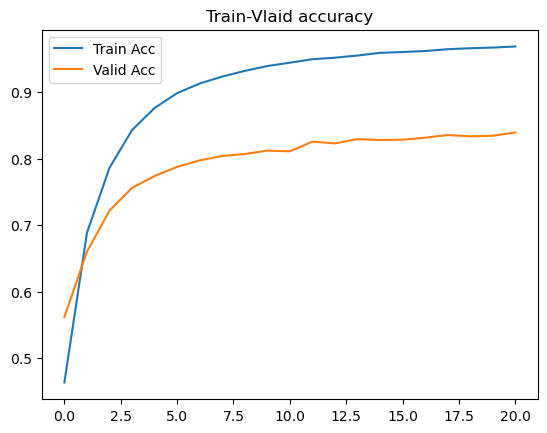

epoch 21 loss: 0.0990: 100%|████████████████| 8725/8725 [44:32<00:00,  3.26it/s]


train accuracy = 0.96975
[[2168    6    9 ...    0    0    0]
 [   7 2146   30 ...    0    0    0]
 [   6   38 2076 ...    0    0    0]
 ...
 [   0    0    0 ... 2150   34    0]
 [   0    0    0 ...   36 2152    0]
 [   0    0    1 ...    0    0 2192]]


epoch 21 loss: 0.6705: 100%|████████████████| 1860/1860 [04:27<00:00,  6.95it/s]


validation accuracy = 0.83992
[[275   3   8 ...   0   0   0]
 [  2 210  31 ...   0   1   0]
 [  1  25 422 ...   0   0   0]
 ...
 [  0   0   0 ... 163  14   0]
 [  0   0   0 ...  27 190   0]
 [  0   0   0 ...   0   0 217]]


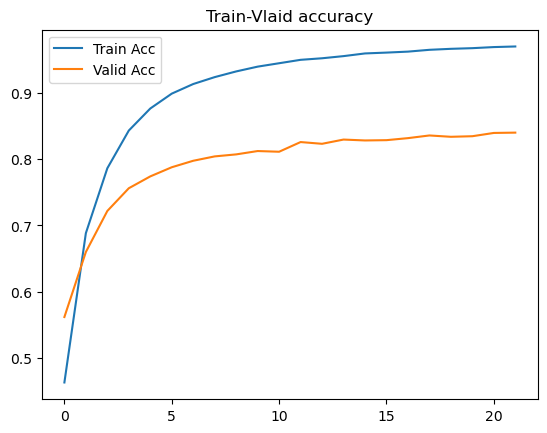

epoch 22 loss: 0.0864: 100%|████████████████| 8725/8725 [44:33<00:00,  3.26it/s]


train accuracy = 0.97178
[[2179   10    3 ...    0    0    0]
 [   8 2145   24 ...    0    0    0]
 [   3   28 2104 ...    0    0    0]
 ...
 [   0    0    0 ... 2160   26    0]
 [   0    1    0 ...   30 2153    0]
 [   0    0    0 ...    0    0 2194]]


epoch 22 loss: 0.7144: 100%|████████████████| 1860/1860 [04:28<00:00,  6.94it/s]


validation accuracy = 0.83931
[[276   5  10 ...   0   0   0]
 [  5 207  34 ...   0   1   0]
 [  3  25 439 ...   0   0   0]
 ...
 [  0   0   0 ... 167  12   0]
 [  0   0   1 ...  24 183   0]
 [  0   0   0 ...   0   0 209]]


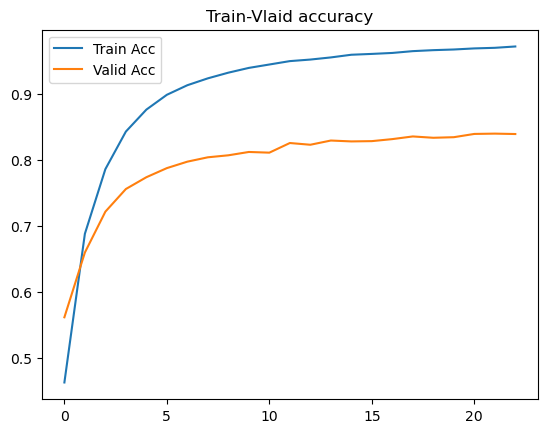

epoch 23 loss: 0.0837: 100%|████████████████| 8725/8725 [44:33<00:00,  3.26it/s]


train accuracy = 0.97250
[[2178   10    3 ...    0    0    0]
 [   9 2150   26 ...    0    0    0]
 [   3   36 2095 ...    0    0    0]
 ...
 [   0    0    0 ... 2154   32    0]
 [   0    0    0 ...   31 2153    0]
 [   0    0    0 ...    0    0 2189]]


epoch 23 loss: 0.6524: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.84402
[[285   3   3 ...   0   0   0]
 [  9 214  29 ...   0   1   0]
 [  8  39 423 ...   1   0   0]
 ...
 [  0   0   0 ... 163  16   0]
 [  1   0   0 ...  20 185   0]
 [  0   0   0 ...   0   0 217]]


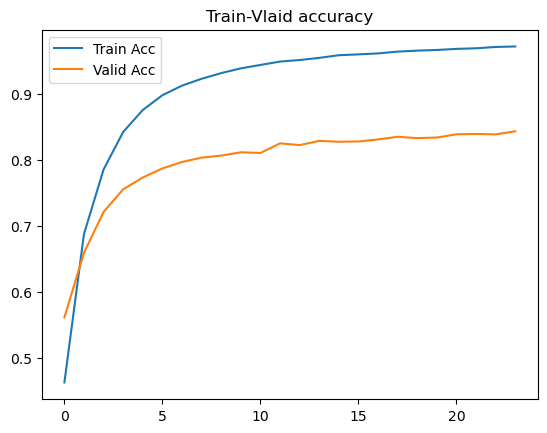

epoch 24 loss: 0.0926: 100%|████████████████| 8725/8725 [44:37<00:00,  3.26it/s]


train accuracy = 0.97307
[[2170    9    4 ...    0    0    0]
 [   7 2157   22 ...    0    0    0]
 [   5   33 2084 ...    0    0    0]
 ...
 [   0    0    0 ... 2151   35    0]
 [   0    0    0 ...   37 2151    0]
 [   0    0    0 ...    0    0 2196]]


epoch 24 loss: 0.6970: 100%|████████████████| 1860/1860 [04:27<00:00,  6.95it/s]


validation accuracy = 0.84399
[[283   3   7 ...   0   0   0]
 [  6 222  17 ...   0   1   0]
 [  4  43 412 ...   0   0   0]
 ...
 [  0   0   0 ... 159  16   0]
 [  0   0   0 ...  22 192   0]
 [  0   0   0 ...   0   0 219]]


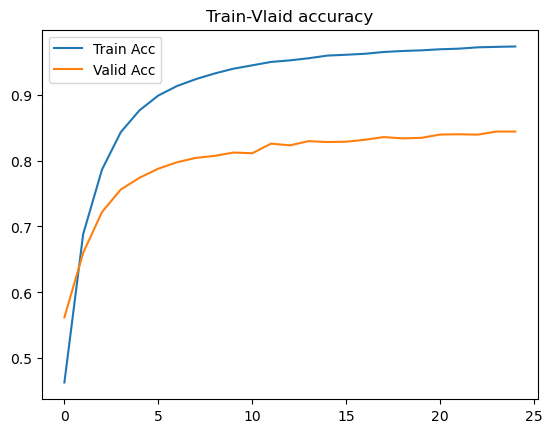

epoch 25 loss: 0.0476: 100%|████████████████| 8725/8725 [44:52<00:00,  3.24it/s]


train accuracy = 0.98244
[[2188    2    4 ...    0    0    0]
 [   4 2167   22 ...    0    0    0]
 [   2   35 2119 ...    0    0    0]
 ...
 [   0    0    0 ... 2174   21    0]
 [   0    0    0 ...   26 2167    0]
 [   0    0    0 ...    0    0 2196]]


epoch 25 loss: 0.6802: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.85497
[[280   4   3 ...   0   0   0]
 [  6 214  30 ...   0   1   0]
 [  4  34 426 ...   0   0   0]
 ...
 [  0   0   0 ... 161  14   0]
 [  0   0   0 ...  20 191   0]
 [  1   0   0 ...   0   0 221]]


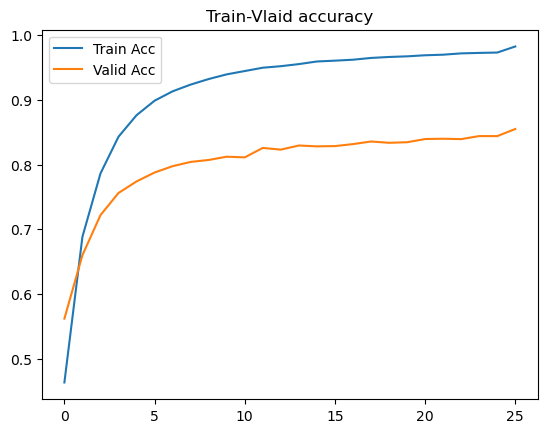

epoch 26 loss: 0.0500: 100%|████████████████| 8725/8725 [44:41<00:00,  3.25it/s]


train accuracy = 0.98488
[[2191    5    1 ...    0    0    0]
 [   2 2181   12 ...    0    0    0]
 [   1   19 2142 ...    0    0    0]
 ...
 [   0    0    0 ... 2183   12    0]
 [   0    0    0 ...   19 2175    0]
 [   0    0    0 ...    0    0 2200]]


epoch 26 loss: 0.6944: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.85689
[[287   1   7 ...   0   0   0]
 [  8 220  25 ...   0   1   0]
 [  2  45 420 ...   0   0   0]
 ...
 [  0   0   0 ... 154  17   0]
 [  1   0   0 ...  12 194   0]
 [  0   0   0 ...   0   0 221]]


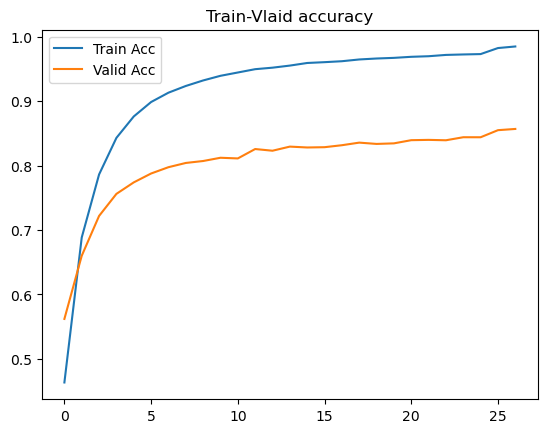

epoch 27 loss: 0.0531: 100%|████████████████| 8725/8725 [44:40<00:00,  3.26it/s]


train accuracy = 0.98511
[[2192    1    1 ...    0    0    0]
 [   4 2173   14 ...    0    0    0]
 [   0   24 2128 ...    0    0    0]
 ...
 [   0    0    0 ... 2184   13    0]
 [   0    0    0 ...   16 2178    0]
 [   0    0    0 ...    0    0 2198]]


epoch 27 loss: 0.7242: 100%|████████████████| 1860/1860 [04:28<00:00,  6.94it/s]


validation accuracy = 0.85578
[[281   4   7 ...   0   0   0]
 [  2 206  42 ...   0   1   0]
 [  2  27 446 ...   0   0   0]
 ...
 [  0   0   0 ... 164  13   0]
 [  0   0   1 ...  16 200   0]
 [  0   0   0 ...   0   0 220]]


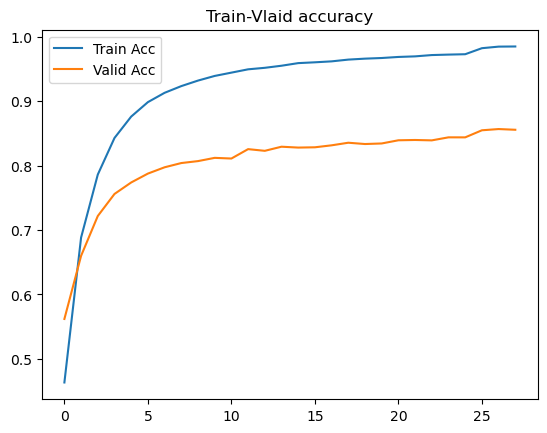

epoch 28 loss: 0.0549: 100%|████████████████| 8725/8725 [44:41<00:00,  3.25it/s]


train accuracy = 0.98644
[[2188    5    1 ...    0    0    0]
 [   7 2180    7 ...    0    0    0]
 [   1   16 2143 ...    0    0    0]
 ...
 [   0    0    0 ... 2182   13    0]
 [   0    0    0 ...   17 2179    0]
 [   0    0    0 ...    0    1 2199]]


epoch 28 loss: 0.6938: 100%|████████████████| 1860/1860 [04:27<00:00,  6.96it/s]


validation accuracy = 0.85934
[[277   4   6 ...   0   0   0]
 [  4 209  36 ...   0   1   0]
 [  3  27 434 ...   0   0   0]
 ...
 [  0   0   0 ... 167  11   0]
 [  0   0   0 ...  21 188   0]
 [  0   0   0 ...   0   0 219]]


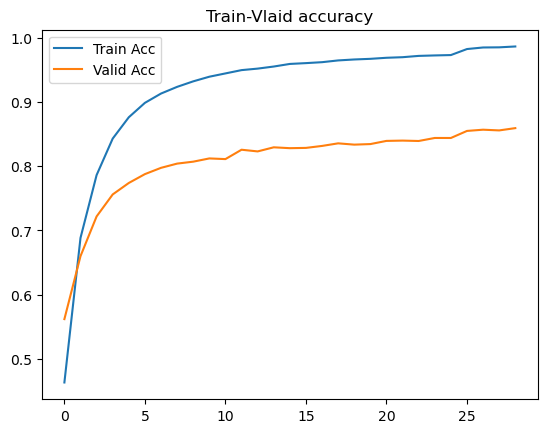

epoch 29 loss: 0.0425: 100%|████████████████| 8725/8725 [44:43<00:00,  3.25it/s]


train accuracy = 0.98723
[[2194    2    0 ...    0    0    0]
 [   4 2173   17 ...    0    0    0]
 [   3   23 2138 ...    0    0    1]
 ...
 [   0    0    0 ... 2186   12    0]
 [   0    0    0 ...   13 2184    0]
 [   0    0    0 ...    0    0 2200]]


epoch 29 loss: 0.6868: 100%|████████████████| 1860/1860 [04:27<00:00,  6.95it/s]


validation accuracy = 0.86011
[[280   4   8 ...   0   0   1]
 [  6 217  23 ...   0   1   0]
 [  1  40 422 ...   0   0   0]
 ...
 [  0   0   0 ... 161  16   0]
 [  0   0   0 ...  21 192   0]
 [  0   0   0 ...   0   0 221]]


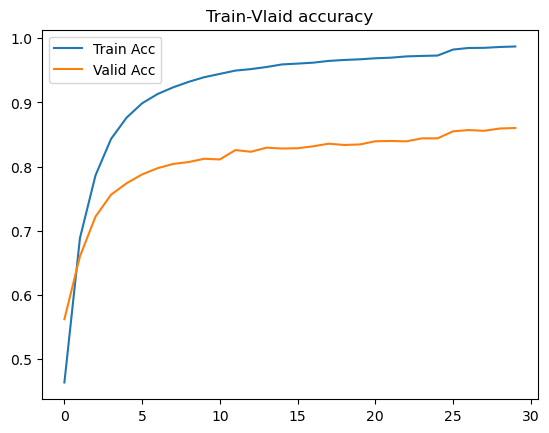

epoch 30 loss: 0.0494: 100%|████████████████| 8725/8725 [44:47<00:00,  3.25it/s]


train accuracy = 0.98755
[[2194    4    2 ...    0    0    0]
 [   2 2185    5 ...    0    0    0]
 [   2   11 2150 ...    0    0    0]
 ...
 [   0    0    0 ... 2187   15    0]
 [   0    0    0 ...   13 2182    0]
 [   0    0    0 ...    0    0 2198]]


epoch 30 loss: 0.6851: 100%|████████████████| 1860/1860 [04:28<00:00,  6.93it/s]


validation accuracy = 0.85840
[[281   5   6 ...   0   0   0]
 [  4 208  33 ...   0   1   0]
 [  3  27 429 ...   0   0   0]
 ...
 [  0   0   0 ... 171   5   0]
 [  0   0   0 ...  27 183   0]
 [  0   0   0 ...   0   0 218]]


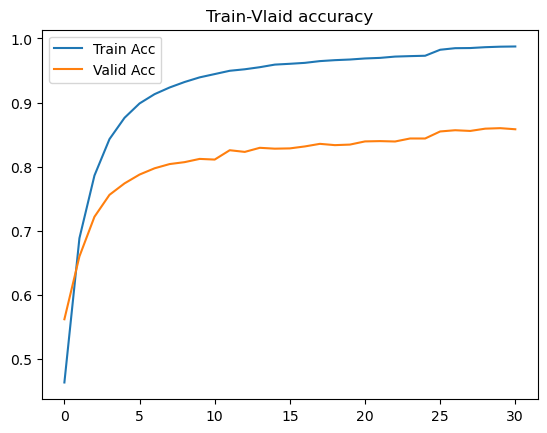

epoch 31 loss: 0.0652: 100%|████████████████| 8725/8725 [44:48<00:00,  3.25it/s]


train accuracy = 0.98773
[[2195    3    3 ...    0    0    0]
 [   2 2182   13 ...    0    0    0]
 [   1   13 2146 ...    0    0    0]
 ...
 [   0    0    0 ... 2191    8    0]
 [   0    0    0 ...   13 2185    0]
 [   0    0    0 ...    0    0 2199]]


epoch 31 loss: 0.7293: 100%|████████████████| 1860/1860 [04:28<00:00,  6.94it/s]


validation accuracy = 0.85702
[[272   8  12 ...   0   0   0]
 [  5 211  33 ...   0   1   0]
 [  0  24 448 ...   0   0   0]
 ...
 [  0   0   0 ... 168   7   0]
 [  0   0   0 ...  21 193   0]
 [  0   0   0 ...   0   0 223]]


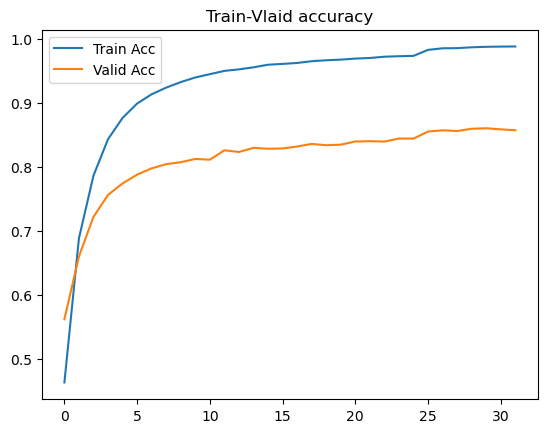

epoch 32 loss: 0.0345: 100%|████████████████| 8725/8725 [44:50<00:00,  3.24it/s]


train accuracy = 0.98863
[[2194    4    0 ...    0    0    0]
 [   5 2181    9 ...    1    0    0]
 [   0   14 2150 ...    0    0    0]
 ...
 [   0    0    0 ... 2186   12    1]
 [   0    0    0 ...    7 2189    0]
 [   0    0    0 ...    0    0 2199]]


epoch 32 loss: 0.7522: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.85837
[[281   6   4 ...   0   0   0]
 [  3 210  34 ...   0   1   0]
 [  8  29 424 ...   0   0   0]
 ...
 [  0   0   0 ... 172   9   0]
 [  0   0   0 ...  23 195   0]
 [  0   0   0 ...   0   0 223]]


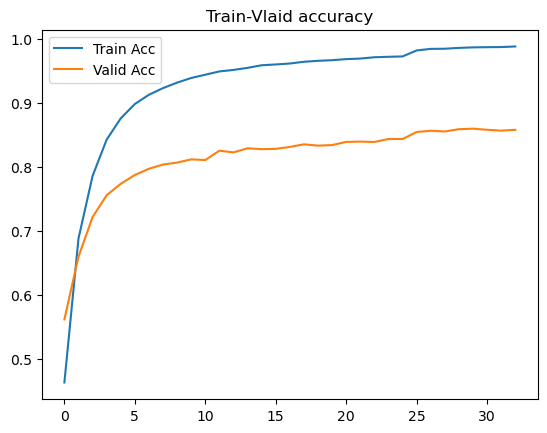

epoch 33 loss: 0.0395: 100%|████████████████| 8725/8725 [44:51<00:00,  3.24it/s]


train accuracy = 0.98888
[[2197    2    0 ...    0    0    0]
 [   3 2173   16 ...    0    0    0]
 [   1   18 2146 ...    0    0    0]
 ...
 [   0    0    0 ... 2192    8    0]
 [   0    0    0 ...   10 2187    0]
 [   0    0    0 ...    0    0 2198]]


epoch 33 loss: 0.7670: 100%|████████████████| 1860/1860 [04:27<00:00,  6.95it/s]


validation accuracy = 0.85880
[[286   3   1 ...   0   0   0]
 [  0 228  21 ...   0   1   0]
 [  3  39 427 ...   0   0   0]
 ...
 [  0   0   0 ... 158   6   0]
 [  0   0   0 ...  24 180   0]
 [  0   0   0 ...   0   0 221]]


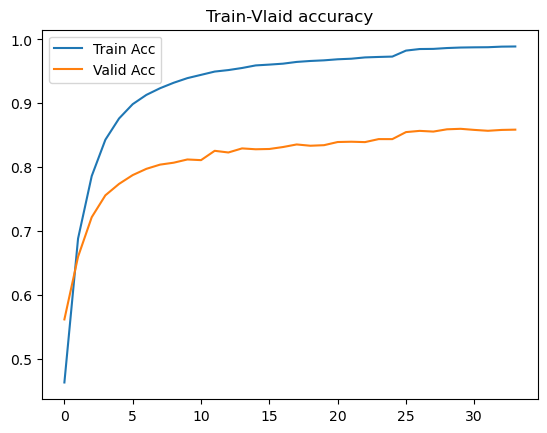

epoch 34 loss: 0.0415: 100%|████████████████| 8725/8725 [44:54<00:00,  3.24it/s]


train accuracy = 0.98897
[[2192    3    2 ...    0    1    0]
 [   1 2178   15 ...    0    0    0]
 [   3   10 2148 ...    0    0    0]
 ...
 [   0    0    0 ... 2192    8    0]
 [   0    0    0 ...   10 2189    0]
 [   0    0    0 ...    0    0 2200]]


epoch 34 loss: 0.7613: 100%|████████████████| 1860/1860 [04:28<00:00,  6.93it/s]


validation accuracy = 0.86008
[[287   2   5 ...   0   0   0]
 [  2 226  26 ...   0   1   0]
 [  3  33 438 ...   0   0   0]
 ...
 [  0   0   0 ... 159  16   0]
 [  0   0   0 ...  13 204   0]
 [  0   0   0 ...   0   0 222]]


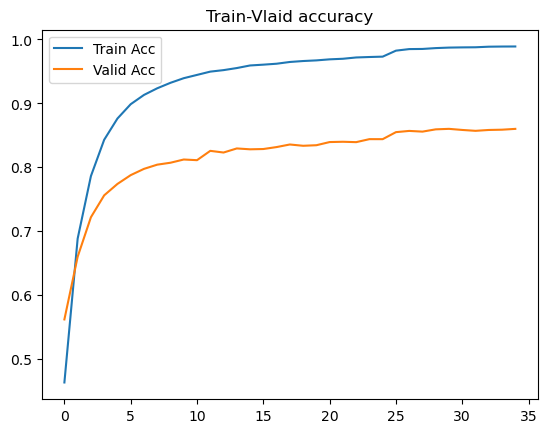

epoch 35 loss: 0.0409: 100%|████████████████| 8725/8725 [45:27<00:00,  3.20it/s]


train accuracy = 0.98941
[[2194    3    1 ...    0    0    0]
 [   3 2184   11 ...    0    0    0]
 [   1   13 2158 ...    0    0    0]
 ...
 [   0    0    0 ... 2190    9    0]
 [   0    0    0 ...   13 2186    0]
 [   0    0    0 ...    0    0 2197]]


epoch 35 loss: 0.7374: 100%|████████████████| 1860/1860 [04:28<00:00,  6.93it/s]


validation accuracy = 0.86163
[[284   3   3 ...   0   0   0]
 [  1 223  27 ...   0   1   0]
 [  2  34 415 ...   0   0   0]
 ...
 [  0   0   0 ... 173   7   0]
 [  0   0   0 ...  29 186   0]
 [  0   0   0 ...   0   0 220]]


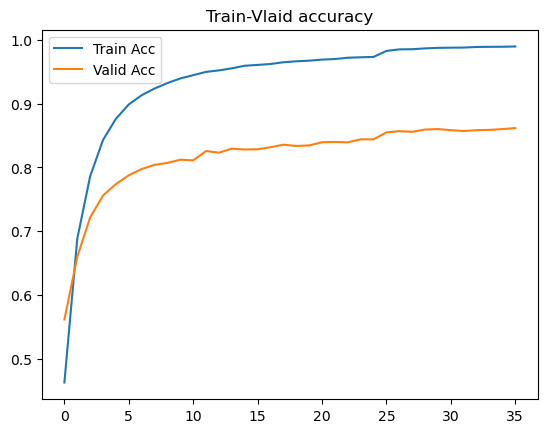

epoch 36 loss: 0.0412: 100%|████████████████| 8725/8725 [44:54<00:00,  3.24it/s]


train accuracy = 0.98933
[[2197    1    2 ...    0    0    0]
 [   5 2177   12 ...    0    0    0]
 [   1   12 2150 ...    0    0    0]
 ...
 [   0    0    0 ... 2186   11    0]
 [   0    0    0 ...   13 2185    0]
 [   0    0    0 ...    0    0 2201]]


epoch 36 loss: 0.7514: 100%|████████████████| 1860/1860 [04:28<00:00,  6.93it/s]


validation accuracy = 0.85968
[[289   1   2 ...   0   0   0]
 [  2 221  27 ...   0   1   0]
 [  6  42 419 ...   0   0   0]
 ...
 [  0   0   0 ... 170   8   0]
 [  0   0   0 ...  21 196   0]
 [  0   0   0 ...   0   0 222]]


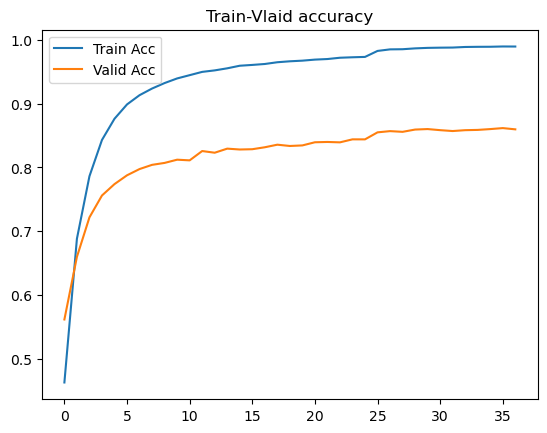

epoch 37 loss: 0.0326: 100%|████████████████| 8725/8725 [44:55<00:00,  3.24it/s]


train accuracy = 0.98994
[[2196    2    2 ...    0    0    0]
 [   1 2180   15 ...    0    0    0]
 [   4   16 2158 ...    0    0    0]
 ...
 [   0    0    0 ... 2190   10    0]
 [   1    0    0 ...   11 2183    0]
 [   0    0    0 ...    0    1 2201]]


epoch 37 loss: 0.7593: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.86035
[[286   0   3 ...   0   0   0]
 [  6 201  43 ...   0   1   0]
 [  3  29 437 ...   0   0   0]
 ...
 [  0   0   0 ... 166   7   0]
 [  0   0   0 ...  15 196   0]
 [  0   0   0 ...   0   0 221]]


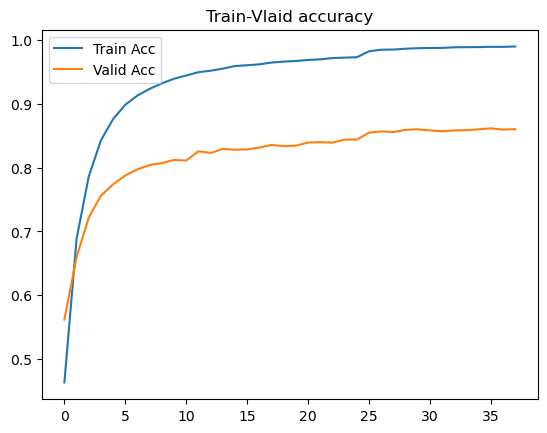

epoch 38 loss: 0.0387: 100%|████████████████| 8725/8725 [44:53<00:00,  3.24it/s]


train accuracy = 0.98983
[[2194    4    2 ...    0    0    0]
 [   2 2188    5 ...    0    0    0]
 [   2    7 2151 ...    0    0    0]
 ...
 [   0    0    0 ... 2193    8    0]
 [   0    0    0 ...   11 2189    0]
 [   0    0    0 ...    0    0 2199]]


epoch 38 loss: 0.7599: 100%|████████████████| 1860/1860 [04:28<00:00,  6.94it/s]


validation accuracy = 0.86001
[[285   4   5 ...   0   0   0]
 [  2 215  32 ...   0   0   0]
 [  5  29 435 ...   0   0   0]
 ...
 [  0   0   0 ... 165  11   0]
 [  1   0   0 ...  19 196   0]
 [  0   0   0 ...   0   0 222]]


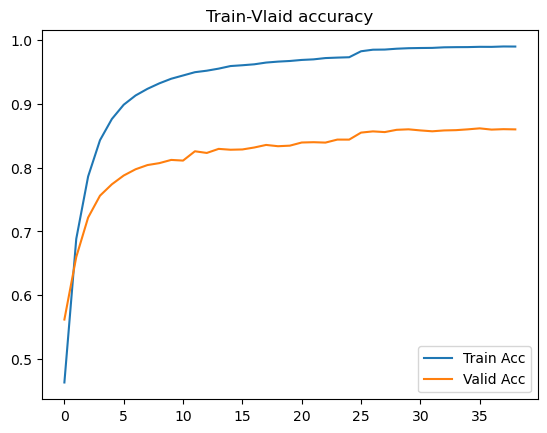

epoch 39 loss: 0.0326: 100%|████████████████| 8725/8725 [44:57<00:00,  3.24it/s]


train accuracy = 0.99055
[[2194    2    1 ...    0    0    0]
 [   2 2189   10 ...    0    0    0]
 [   2   14 2158 ...    0    0    0]
 ...
 [   0    1    0 ... 2188   11    0]
 [   0    0    0 ...   10 2189    0]
 [   0    0    0 ...    0    0 2200]]


epoch 39 loss: 0.7479: 100%|████████████████| 1860/1860 [04:27<00:00,  6.94it/s]


validation accuracy = 0.86213
[[284   1   2 ...   0   0   0]
 [  2 221  28 ...   0   1   0]
 [  1  35 440 ...   0   0   0]
 ...
 [  0   0   0 ... 174   6   0]
 [  0   0   0 ...  23 198   0]
 [  0   0   0 ...   0   0 219]]


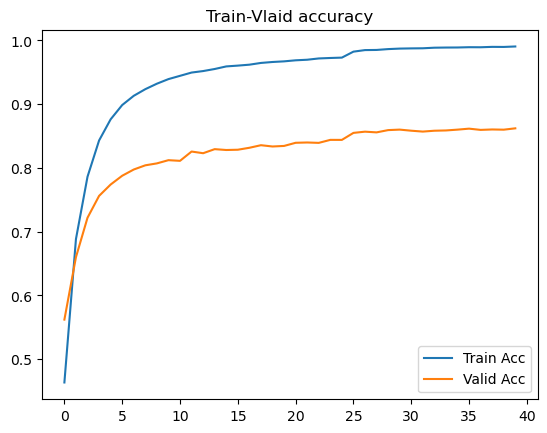

time : 1 day, 8:41:09
Best Epoch : 39/ 40
Best Train Accuracy : 0.99055
[[2194    2    1 ...    0    0    0]
 [   2 2189   10 ...    0    0    0]
 [   2   14 2158 ...    0    0    0]
 ...
 [   0    1    0 ... 2188   11    0]
 [   0    0    0 ...   10 2189    0]
 [   0    0    0 ...    0    0 2200]]
Best Valid Accuracy : 0.86213
[[284   1   2 ...   0   0   0]
 [  2 221  28 ...   0   1   0]
 [  1  35 440 ...   0   0   0]
 ...
 [  0   0   0 ... 174   6   0]
 [  0   0   0 ...  23 198   0]
 [  0   0   0 ...   0   0 219]]


AttributeError: 'DataParallel' object has no attribute 'cnn_model'

AttributeError: 'DataParallel' object has no attribute 'cnn_model'

In [11]:
%run classification_train_efficientnet2.ipynb

In [18]:
print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 38/ 40
Best Train Accuracy : 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]
Best Valid Accuracy : 0.88483
[[255  10   2 ...   0   0   0]
 [  6 196   0 ...   0   0   0]
 [  3   0 389 ...   0   0   0]
 ...
 [  0   0   0 ... 178   5   0]
 [  0   0   0 ...  12 208   0]
 [  0   0   0 ...   0   0 218]]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


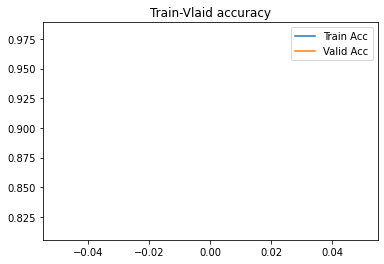

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


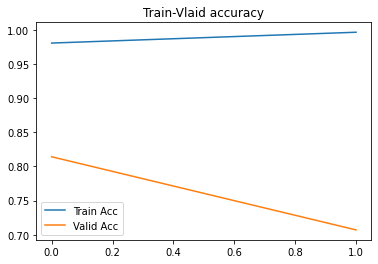

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


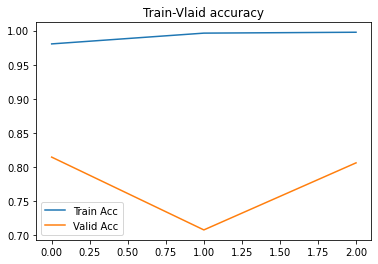

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


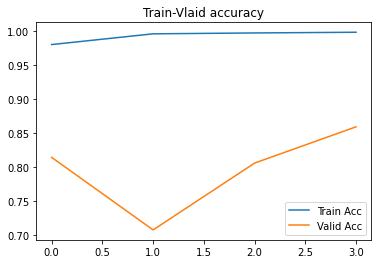

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


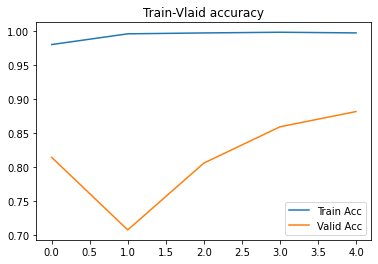

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb